# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

In [1]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *

/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [mlsInterMiami].[ds].[getRetentionScoringModelData] 113 """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6941, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6941 entries, 0 to 6940
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6941 non-null   int64  
 1   year                 6941 non-null   int64  
 2   productGrouping      6941 non-null   object 
 3   email                6923 non-null   object 
 4   ticketingid          6941 non-null   object 
 5   totalSpent           6941 non-null   float64
 6   recentDate           6941 non-null   object 
 7   attendancePercent    6941 non-null   float64
 8   renewedBeforeDays    6941 non-null   int64  
 9   source_tenure        6941 non-null   int64  
 10  tenure               6941 non-null   int64  
 11  distToVenue          6734 non-null   float64
 12  recency              6941 non-null   int64  
 13  missed_games_1       6941 non-null   int64  
 14  missed_games_2       6941 non-null   int64  
 15  missed_games_over_2  6941 non-null   i

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "email",
            "ticketingid",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3599, 17)
Unseen Data For Predictions: (635, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","email","productGrouping","ticketingid","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6342,0.6996,0.6860,0.6139,0.6473,0.2698,0.2724,0.7220


In [8]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6634,0.7221,0.7000,0.6442,0.6709,0.3277,0.3288
1,0.5915,0.6687,0.6200,0.5776,0.5981,0.1838,0.1843
2,0.6536,0.6992,0.7600,0.6196,0.6826,0.3099,0.3178
3,0.6275,0.6929,0.6867,0.6059,0.6437,0.2565,0.2587
4,0.6438,0.6960,0.6600,0.6306,0.6450,0.2879,0.2882
5,0.6340,0.6979,0.6867,0.6131,0.6478,0.2694,0.2713
6,0.6013,0.7102,0.6467,0.5843,0.6139,0.2039,0.2051
7,0.5915,0.6373,0.6933,0.5683,0.6246,0.1861,0.1906
8,0.6340,0.7047,0.6200,0.6284,0.6242,0.2675,0.2675


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2707, 17)

In [10]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7514,0,0.0000,0.0000,0.0000,0.0000,0.0000


In [11]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")

lightgbm:
 0    2034
1     673
Name: Label, dtype: int64


In [12]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    1141
(0.25, 0.5]        893
(0.5, 0.75]        593
(0.75, 1.0]         80
Name: Score_1, dtype: int64


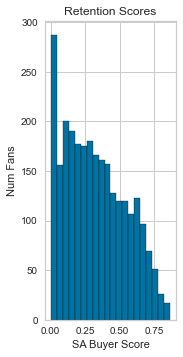

In [13]:
model_predictions = [lightgbm_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

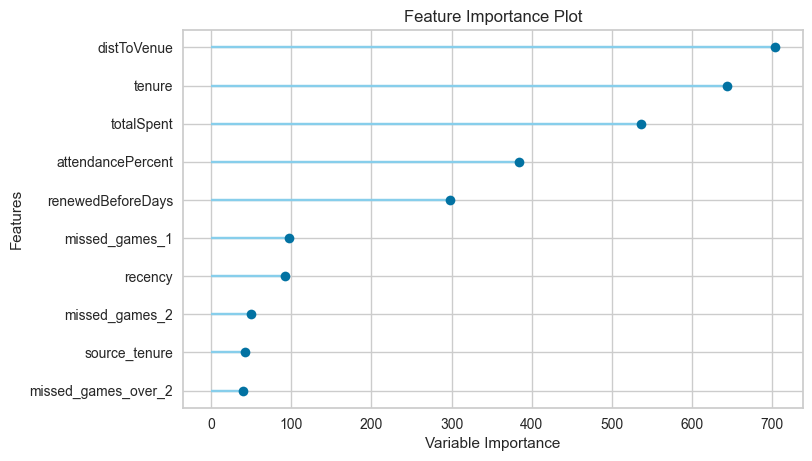

In [14]:
plot_model(lightgbm_model, plot='feature')

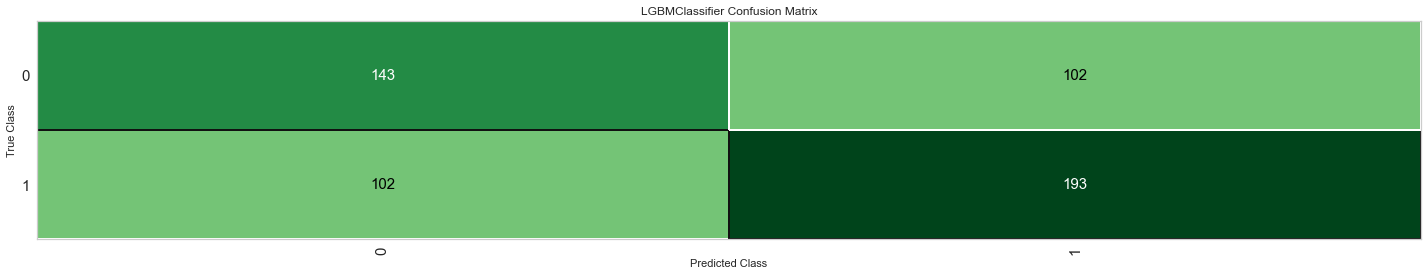

In [15]:
plot_model(lightgbm_model, plot='confusion_matrix')

In [16]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,email,ticketingid,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
2,52,2022,Full Season,06guer1103@gmail.com,253859,1926.10,2022-08-20,0.96,96,730,746,3763.40,0,1,0,0,0,1,0.4992,0.5008
5,179,2022,Flex Plan,195cleanup@gmail.com,270764,312.00,2022-07-13,0.88,10,730,150,38.20,0,0,0,0,0,0,0.9960,0.0040
9,466,2022,Full Season,4jcmas@gmail.com,232105,12257.00,2022-08-20,0.60,162,730,949,48.37,0,1,0,1,0,1,0.4571,0.5429
12,530,2022,Full Season,6xiirt@gmail.com,277117,875.50,2022-08-20,0.62,159,730,950,57.52,0,2,2,0,0,0,0.8391,0.1609
15,632,2022,Full Season,9espi9@gmail.com,295807,439.84,1970-01-01,0.00,162,730,752,47.79,0,0,0,1,0,0,0.9109,0.0891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6914,149774,2022,Full Season,zs@dzdgroup.com,186312,12257.00,2022-08-20,0.65,162,1095,1098,27.58,0,3,0,0,0,1,0.4546,0.5454
6917,149844,2022,Full Season,zunigajulian@hotmail.com,127107,1575.90,2022-08-13,0.27,162,1095,948,47.74,0,1,1,2,0,0,0.7869,0.2131
6933,400093,2022,Flex Plan,tjvillamil741@gmail.com,1349159,402.00,2022-07-13,1.00,15,0,33,59.73,0,0,0,0,0,0,0.9994,0.0006
6937,874335,2022,Full Season,china22ayelen@gmail.com,188409,437.75,2022-08-20,0.69,159,1095,1054,42.19,1,2,0,1,0,0,0.8265,0.1735


In [17]:
current_date = datetime.today().strftime('%Y-%m-%d')
lightgbm_predictions.to_json(f"Results/InterMiami_Retention_Scores_{current_date}.csv.out", orient="records")
#lightgbm_predictions.to_csv(f"Results/InterMiami_Retention_Scores_{current_date}.csv", index=False)

### Done